In [1]:
import random

import gym
import torch as th
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from torch.nn import functional as F

In [2]:
env = gym.make("CartPole-user")

D:\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [3]:
class PolicyNet(nn.Module):
	def __init__(self, state_dim, hidden_dim, action_dim):
		super(PolicyNet, self).__init__()
		self.fc1 = nn.Linear(state_dim, hidden_dim)
		self.fc2 = nn.Linear(hidden_dim, action_dim)

	def forward(self, x):
		x = F.relu(self.fc1(x))
		return F.softmax(self.fc2(x), dim=1)

In [4]:
class ValueNet(nn.Module):
	def __init__(self, state_dim, hidden_dim):
		super(ValueNet, self).__init__()
		self.fc1 = nn.Linear(state_dim, hidden_dim)
		self.fc2 = nn.Linear(hidden_dim, 1)

	def forward(self, x):
		x = F.relu(self.fc1(x))
		return self.fc2(x)

In [5]:
def compute_advantage(gamma, lambda_, td_delta):
	td_delta = td_delta.cpu().detach().numpy()
	advantage_list = []
	advantage = 0.0
	for delta in td_delta[::-1]:
		advantage = gamma * lambda_ * advantage + delta
		advantage_list.append(advantage)
	advantage_list.reverse()
	return th.tensor(advantage_list, dtype=th.float)

In [6]:
class PPO:
	""" PPO算法，采用截断方式 """

	def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lambda_, epochs, eps, gamma):
		self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
		self.critic = ValueNet(state_dim, hidden_dim).to(device)
		self.actor_optimizer = th.optim.Adam(self.actor.parameters(), lr=actor_lr)
		self.critic_optimizer = th.optim.Adam(self.critic.parameters(), lr=critic_lr)
		self.gamma = gamma
		self.lambda_ = lambda_
		self.epochs = epochs
		self.eps = eps

	def take_action(self, state):
		state = th.tensor([state], dtype=th.float).to(device)
		probs = self.actor(state)
		action_dist = th.distributions.Categorical(probs)
		action = action_dist.sample()
		return action.item()

	def update(self, transition_dict):
		states = th.tensor(transition_dict["states"], dtype=th.float).to(device)
		actions = th.tensor(transition_dict["actions"], dtype=th.float).view(-1, 1).to(device)
		rewards = th.tensor(transition_dict["rewards"], dtype=th.float).view(-1, 1).to(device)
		next_states = th.tensor(transition_dict["next_states"], dtype=th.float).to(device)
		dones = th.tensor(transition_dict["dones"], dtype=th.float).view(-1, 1).to(device)
		td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones).to(device)
		td_delta = td_target - self.critic(states)
		advantage = compute_advantage(self.gamma, self.lambda_, td_delta).to(device)
		old_log_probs = th.log(self.actor(states).gather(1, actions.type(th.int64))).detach()

		for _ in range(self.epochs):
			log_probs = th.log(self.actor(states).gather(1, actions.type(th.int64)))
			ratio = th.exp(log_probs - old_log_probs)
			surr1 = ratio * advantage
			surr2 = th.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
			actor_loss = th.mean(-th.min(surr1, surr2))
			critic_loss = th.mean(F.mse_loss(self.critic(states), td_target.detach()))
			self.actor_optimizer.zero_grad()
			self.critic_optimizer.zero_grad()
			actor_loss.backward()
			critic_loss.backward()
			self.actor_optimizer.step()
			self.critic_optimizer.step()

In [7]:
def train_on_policy_agent(env, agent, num_episodes):
	return_list = []
	for i in range(epochs):
		with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
			for i_episode in range(int(num_episodes / 10)):
				episode_return = 0
				transition_dict = {"states": [], "actions": [], "next_states": [], "rewards": [], "dones": []}
				state = env.reset()
				done = False
				while not done:
					action = agent.take_action(state)
					next_state, reward, done, _ = env.step(action)

					transition_dict["states"].append(state)
					transition_dict["actions"].append(action)
					transition_dict["next_states"].append(next_state)
					transition_dict["rewards"].append(reward)
					transition_dict["dones"].append(done)
					state = next_state
					episode_return += reward
				return_list.append(episode_return)
				agent.update(transition_dict)
				if (i_episode + 1) % 10 == 0:
					pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
					                  'return': '%.3f' % np.mean(return_list[-10:])})
				pbar.update(1)
	return return_list

In [8]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 300
hidden_dim = 128
gamma = 0.98
lambda_ = 0.95
epochs = 10
eps = 0.2

device = th.device("cuda") if th.cuda.is_available() else th.device("cpu")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
ppo_agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lambda_, epochs, eps, gamma)

print(f"device: {device}")

device: cuda


In [9]:
return_list = train_on_policy_agent(env, ppo_agent, num_episodes)

Iteration 0:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\liu_z\AppData\Local\Temp\ipykernel_24552\2478470367.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  state = th.tensor([state], dtype=th.float).to(device)
Iteration 9: 100%|██████████| 30/30 [00:19<00:00,  1.55it/s, episode=300, return=500.000]


In [10]:
def sample_expert_data(n_episode):
    states = []
    actions = []
    for episode in range(n_episode):
        state = env.reset()
        done = False
        while not done:
            action = ppo_agent.take_action(state)
            states.append(state)
            actions.append(action)
            next_state, reward, done, _ = env.step(action)
            state = next_state
    return np.array(states), np.array(actions)

In [11]:
n_episode = 1
expert_s, expert_a = sample_expert_data(n_episode)

n_samples = 30  # 采样30个数据
random_index = random.sample(range(expert_s.shape[0]), n_samples)
expert_s = expert_s[random_index]
expert_a = expert_a[random_index]

In [12]:
class Discriminator(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Discriminator, self).__init__()
        self.fc1 = th.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = th.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = th.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        return th.sigmoid(self.fc2(x))

In [13]:
class GAIL:
    def __init__(self, agent, state_dim, action_dim, hidden_dim, lr_d):
        self.discriminator = Discriminator(state_dim, hidden_dim, action_dim).to(device)
        self.discriminator_optimizer = th.optim.Adam(self.discriminator.parameters(), lr=lr_d)
        self.agent = agent

    def learn(self, expert_s, expert_a, agent_s, agent_a, next_s, dones):
        expert_states = th.tensor(expert_s, dtype=th.float).to(device)
        expert_actions = th.tensor(expert_a, dtype=th.int64).to(device)
        agent_states = th.tensor(agent_s, dtype=th.float).to(device)
        agent_actions = th.tensor(agent_a, dtype=th.int64).to(device)
        expert_actions = F.one_hot(expert_actions, num_classes=2).float()
        agent_actions = F.one_hot(agent_actions, num_classes=2).float()

        expert_prob = self.discriminator(expert_states, expert_actions)
        agent_prob = self.discriminator(agent_states, agent_actions)
        discriminator_loss = nn.BCELoss()(agent_prob, th.ones_like(agent_prob)) + nn.BCELoss()(expert_prob, th.zeros_like(expert_prob))
        self.discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        self.discriminator_optimizer.step()

        rewards = -th.log(agent_prob).detach().cpu().numpy()
        transition_dict = {
            'states': agent_s,
            'actions': agent_a,
            'rewards': rewards,
            'next_states': next_s,
            'dones': dones
        }
        self.agent.update(transition_dict)

In [15]:
lr_d = 1e-3
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lambda_, epochs, eps, gamma)
gail = GAIL(agent, state_dim, action_dim, hidden_dim, lr_d)
n_episode = 300
return_list = []

with tqdm(total=n_episode, desc="进度条") as pbar:
    for i in range(n_episode):
        episode_return = 0
        state = env.reset()
        done = False
        state_list = []
        action_list = []
        next_state_list = []
        done_list = []
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, _ = env.step(action)
            state_list.append(state)
            action_list.append(action)
            next_state_list.append(next_state)
            done_list.append(done)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
        gail.learn(expert_s, expert_a, state_list, action_list, next_state_list, done_list)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)

进度条: 100%|██████████| 300/300 [02:40<00:00,  1.87it/s, return=450.000]


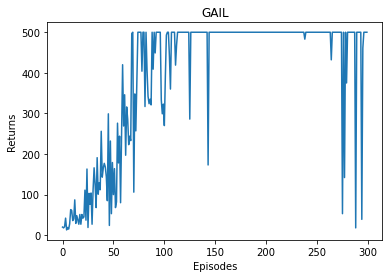

In [16]:
iteration_list = list(range(len(return_list)))
plt.plot(iteration_list, return_list)
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.title("GAIL")
plt.show()

In [23]:
lr_d = 1e-3
expert = ppo_agent
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lambda_, epochs, eps, gamma)
gail = GAIL(agent, state_dim, action_dim, hidden_dim, lr_d)
n_episode = 300
return_list = []

with tqdm(total=n_episode, desc="进度条") as pbar:
    for i in range(n_episode):
        episode_return = 0
        state = env.reset()
        done = False
        state_list = []
        action_list = []
        next_state_list = []
        done_list = []
        while not done:
            expert_action = expert.take_action(state)
            agent_action = agent.take_action(state)
            next_state, agent_reward, done, _ = env.step(agent_action)
            dummy_next_state, expert_reward, dummy_done, _, _ = env.expert_step(expert_action)

            if not done and expert_reward < agent_reward:
                np.append(expert_s, np.expand_dims(state, axis=0), axis=0)
                np.append(expert_a, np.expand_dims(agent_action, axis=0), axis=0)

            state_list.append(state)
            action_list.append(agent_action)
            next_state_list.append(next_state)
            done_list.append(done)
            state = next_state
            episode_return += agent_reward
        return_list.append(episode_return)
        gail.learn(expert_s, expert_a, state_list, action_list, next_state_list, done_list)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)

进度条: 100%|██████████| 300/300 [05:12<00:00,  1.04s/it, return=500.000]


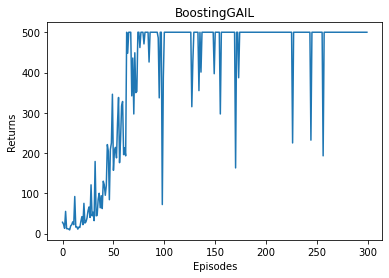

In [24]:
iteration_list = list(range(len(return_list)))
plt.plot(iteration_list, return_list)
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.title("BoostingGAIL")
plt.show()